In [1]:
import pandas as pd

In [2]:
adv_suffixes = {
                    'а', 'ажды', 'ами', 'ах',
                    'е', 'ем', 'ём', 'ему', 'енько', 'еньку', 'ёхонько', 'ёшенько',
                    'жды',
                    'и', 'ик', 'иком', 'их', 'ишом', 'ичн',
                    'ка', 'ками', 'ках', 'ки', 'ко', 'кой', 'ком', 'ку',
                    'мя',
                    'но', 'няком',
                    'о', 'овато', 'ое', 'ой', 'ок', 'ом', 'ому', 'онько', 'оньку', 'остью', 'оту', 'охонько', 'ошенько',
                    'ою', 'ожды',
                    'ства',
                    'у', 'уном', 'учи', 'ую',
                    'ы', 'ые', 'ым', 'ых', 'ышком',
                    'ья',
                    'ю',
                    'я', 'як', 'яка', 'ями', 'ях',
                    ''
                }

adv_prefixes = {
                    'а',
                    'без',
                    'в', 'во',
                    'до',
                    'за',
                    'из', 'ис',
                    'к',
                    'на', 'не',
                    'о', 'ом', 'от', 'ото',
                    'по', 'под', 'поза', 'после', 'про',
                    'с', 'со', 'сыз',
                    'у',
                    ''
                }

In [3]:
class Substr1:
    """
    Класс для хранения информации о словообразовательных моделях.
    idx --- уникальный номер; int
    pos --- часть речи: NOUN, VERB, ADJ, ADV, NUM, OTHER; str / enum
    wl --- заменяемый prefix; str
    wr --- заменяемый suffix; str
    wl_after --- статистика "буква после prefix" до и после, сколько раз; dict((до_замены, после_замены): count)
    wr_before --- статистика "буква перед suffix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    
    Пример. Для слова "по]утр[у" <- "утро" имеем модель:
           (0, 'по', 'у', ADV)
            pos = ADV, wl = 'по', wr = 'у', wl_after = {('у', 'у'): 1}, wr_before = {('р', 'р'): 1} 
    """
    def __init__(self, idx: int=None, pos: str=None, wl: str=None, wr: str=None, example: str=None):
        self.idx = idx
        self.pos = pos
        self.wl = wl
        self.wr = wr
        self.wl_after = dict()
        self.wr_before = dict()
        self.
        self.example = example
        
class Substr2:
    """
    Класс для хранения информации о чередованиях (пока только для одной буквы на стыке основы и морфемы).
    idx --- уникальный номер
    cl --- символ слева
    cr --- символ справа
    cl_after --- статистика "буква после prefix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    cr_before --- статистика "буква перед suffix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    
    Пример. Для слов "по](и)грат(ь)[" <- "](и)грат(ь)[" и "под](ы)грать[" <- "](и)грать[" имеем модели:
            (0, '', '') # перед (и) и после (ь) в обоих случаях
            cl = '', cr = '', cl_after = {('и', 'и'): 1, ('и', 'ы'): 1}, cr_before = {('', ''): 2}
    """
    def __init__(self, idx: int=None, cl: str=None, cr: str=None):
        self.idx = idx
        self.cl = cl
        self.cr = cr
        self.cl_after = dict()
        self.cr_before = dict()

In [5]:
df_adv = pd.read_csv('parsed_ADV.csv', index_col=False)

In [6]:
df_adv.head()

par pos_a pos_b        w_a         w_b   wf  xc_a  xc_b  xl_a  xl_b  xr_a  \
0  977   ADV   ADJ     быстро     быстрый  suf     5     5     0     0     6   
1  977   ADV   ADJ      смело      смелый  suf     4     4     0     0     5   
2  977   ADV   ADJ   привычно   привычный  suf     7     7     0     0     8   
3  977   ADV   ADJ      зябко      зябкий  suf     4     4     0     0     5   
4  977   ADV   ADJ  прощально  прощальный  suf     8     8     0     0     9   

   xr_b  
0     7  
1     6  
2     9  
3     6  
4    10

In [7]:
g1 = list() # замена подстрок одного слова на подстроки другого
g2 = list() # наоборот

deriv_array = list()
deriv_codes = dict()
deriv_codes_inv = dict()

motivators = set()
motivated = set()

g_r_before = list() # граф: какая пара букв в какую перешла
g_r_after = list() # обратный к нему

g_r_2lvl_before = dict()
g_r_2lvl_after = dict()

g_l_before = list() # граф: какая пара букв в какую перешла
g_l_after = list() # обратный к нему

g_l_2lvl_before = dict()
g_l_2lvl_after = dict()

letters_r_array = list()
letters_r_codes = dict() # по паре символов выдает код
letters_r_codes_inv = dict() # наоборот

letters_l_array = list()
letters_l_codes = dict() # аналогично
letters_l_codes_inv = dict()


all_replaces_pairs = list()


for i in range(df_adv.shape[0]):

    w_b = df_adv[i:i+1]['w_b'].tolist()[0].strip()
    w_a = df_adv[i:i+1]['w_a'].tolist()[0].strip()
    pos_b = df_adv[i:i+1]['pos_b'].tolist()[0].strip()
    pos_a = df_adv[i:i+1]['pos_a'].tolist()[0].strip()
    
    # print(i, w_b, w_a)
    
    xc_a = df_adv[i:i+1]['xc_a'].tolist()[0]
    xc_b = df_adv[i:i+1]['xc_b'].tolist()[0]
    xl_a = df_adv[i:i+1]['xl_a'].tolist()[0]
    xl_b = df_adv[i:i+1]['xl_b'].tolist()[0]
    xr_a = df_adv[i:i+1]['xr_a'].tolist()[0]
    xr_b = df_adv[i:i+1]['xr_b'].tolist()[0]

    substr_b = (w_b[:xl_b], w_b[xc_b:], pos_b)
    substr_a = (w_a[:xl_a], w_a[xc_a:], pos_a)
    
    if substr_b not in deriv_codes:
        deriv_codes_inv[len(deriv_array)] = substr_b
        deriv_codes[substr_b] = len(deriv_array)
        g1.append([])
        g2.append([])
        new_b = Substr1(len(deriv_array), pos_b, w_b[:xl_b], w_b[xc_b:], w_b)
        deriv_array.append(new_b)

    if substr_a not in deriv_codes:
        deriv_codes_inv[len(deriv_array)] = substr_a
        deriv_codes[substr_a] = len(deriv_array)
        g1.append([])
        g2.append([])
        new_a = Substr1(len(deriv_array), pos_a, w_a[:xl_a], w_a[xc_a:], w_a)
        deriv_array.append(new_a)
    
    ind_b = deriv_codes[substr_b]
    ind_a = deriv_codes[substr_a]
    
    motivators |= {ind_b}
    motivated |= {ind_a}
    
    g1[ind_b].append(ind_a)
    g2[ind_a].append(ind_b)
    
    cl_b = '' if xl_b == 0 else w_b[xl_b - 1]
    cr_b = '' if xc_b == xr_b else w_b[xc_b]
    
    wl_b = '' if xl_b >= xr_b else w_b[xl_b]
    wr_b = '' if xc_b <= 0 else w_b[xc_b - 1]
    
    cl_a = '' if xl_a == 0 else w_a[xl_a - 1]
    cr_a = '' if xc_a == xr_a else w_a[xc_a]

    wl_a = '' if xl_a >= xr_a else w_a[xl_a]
    wr_a = '' if xc_a <= 0 else w_a[xc_a - 1]
    
    # приставка - корень
    if (cl_b, wl_b) not in deriv_array[ind_b].wl_after:
        deriv_array[ind_b].wl_after[(cl_b, wl_b)] = 1
    else:
        deriv_array[ind_b].wl_after[(cl_b, wl_b)] += 1
    
    if (cl_a, wl_a) not in deriv_array[ind_a].wl_after:
        deriv_array[ind_a].wl_after[(cl_a, wl_a)] = 1
    else:
        deriv_array[ind_a].wl_after[(cl_a, wl_a)] += 1
    
    # корень - суффикс
    if (cr_b, wr_b) not in deriv_array[ind_b].wr_before:
        deriv_array[ind_b].wr_before[(cr_b, wr_b)] = 1
    else:
        deriv_array[ind_b].wr_before[(cr_b, wr_b)] += 1
    
    if (cr_a, wr_a) not in deriv_array[ind_a].wr_before:
        deriv_array[ind_a].wr_before[(cr_a, wr_a)] = 1
    else:
        deriv_array[ind_a].wr_before[(cr_a, wr_a)] += 1
        
        
    letter_pair_r_b = (wr_b, cr_b)
    letter_pair_r_a = (wr_a, cr_a)
    
    letter_pair_l_b = (wl_b, cl_b)
    letter_pair_l_a = (wl_a, cl_a)
    
    # print(letter_pair_l_b, letter_pair_l_a, letter_pair_r_b, letter_pair_r_a)
    
    if letter_pair_r_b not in letters_r_codes:
        letters_r_codes_inv[len(letters_r_codes)] = letter_pair_r_b
        letters_r_codes[letter_pair_r_b] = len(letters_r_codes)
        g_r_before.append([])
        g_r_after.append([])

    if letter_pair_r_a not in letters_r_codes:
        letters_r_codes_inv[len(letters_r_codes)] = letter_pair_r_a
        letters_r_codes[letter_pair_r_a] = len(letters_r_codes)
        g_r_before.append([])
        g_r_after.append([])

    if letter_pair_l_b not in letters_l_codes:
        letters_l_codes_inv[len(letters_l_codes)] = letter_pair_l_b
        letters_l_codes[letter_pair_l_b] = len(letters_l_codes)
        g_l_before.append([])
        g_l_after.append([])

    if letter_pair_l_a not in letters_l_codes:
        letters_l_codes_inv[len(letters_l_codes)] = letter_pair_l_a
        letters_l_codes[letter_pair_l_a] = len(letters_l_codes)
        g_l_before.append([])
        g_l_after.append([])
        
    g_r_before[letters_r_codes[letter_pair_r_b]].append(letters_r_codes[letter_pair_r_a])
    g_l_before[letters_l_codes[letter_pair_l_b]].append(letters_l_codes[letter_pair_l_a])
    
    g_r_after[letters_r_codes[letter_pair_r_a]].append(letters_r_codes[letter_pair_r_b])
    g_l_after[letters_l_codes[letter_pair_l_a]].append(letters_l_codes[letter_pair_l_b])
    
    
    
    
    
    # буква приставки - буква корня
    if letter_pair_l_b not in g_l_2lvl_before:
        g_l_2lvl_before[letter_pair_l_b] = 1
    else:
        g_l_2lvl_before[letter_pair_l_b] += 1
    
    if letter_pair_l_a not in g_l_2lvl_after:
        g_l_2lvl_after[letter_pair_l_a] = 1
    else:
        g_l_2lvl_after[letter_pair_l_a] += 1
    
    # буква корня - буква суффикса
    if letter_pair_r_b not in g_r_2lvl_before:
        g_r_2lvl_before[letter_pair_r_b] = 1
    else:
        g_r_2lvl_before[letter_pair_r_b] += 1
    
    if letter_pair_r_a not in g_r_2lvl_after:
        g_r_2lvl_after[letter_pair_r_a] = 1
    else:
        g_r_2lvl_after[letter_pair_r_a] += 1

In [8]:
g_l_2lvl_after

{('', 'о'): 1,
 ('а', ''): 2,
 ('а', '-'): 2,
 ('б', ''): 19,
 ('б', ' '): 1,
 ('б', '-'): 2,
 ('б', 'а'): 2,
 ('б', 'в'): 2,
 ('б', 'о'): 3,
 ('б', 'с'): 1,
 ('в', ''): 27,
 ('в', ' '): 2,
 ('в', '-'): 2,
 ('в', 'а'): 14,
 ('в', 'в'): 4,
 ('в', 'е'): 2,
 ('в', 'з'): 1,
 ('в', 'к'): 1,
 ('в', 'о'): 9,
 ('в', 'с'): 3,
 ('г', ''): 7,
 ('г', '-'): 1,
 ('г', 'а'): 5,
 ('г', 'в'): 2,
 ('г', 'о'): 2,
 ('г', 'с'): 2,
 ('д', ''): 27,
 ('д', '-'): 5,
 ('д', 'а'): 9,
 ('д', 'в'): 12,
 ('д', 'е'): 2,
 ('д', 'з'): 7,
 ('д', 'о'): 3,
 ('д', 'с'): 1,
 ('е', ''): 2,
 ('е', 'а'): 2,
 ('е', 'о'): 1,
 ('ж', ''): 6,
 ('ж', 'а'): 1,
 ('ж', 'в'): 1,
 ('ж', 'з'): 1,
 ('з', ''): 8,
 ('з', ' '): 1,
 ('з', '-'): 1,
 ('з', 'а'): 3,
 ('з', 'в'): 4,
 ('з', 'е'): 2,
 ('з', 'з'): 1,
 ('з', 'о'): 2,
 ('з', 'с'): 1,
 ('и', ''): 1,
 ('и', 'а'): 1,
 ('и', 'о'): 2,
 ('к', ''): 14,
 ('к', '-'): 3,
 ('к', 'а'): 6,
 ('к', 'в'): 7,
 ('к', 'е'): 1,
 ('к', 'о'): 2,
 ('к', 'с'): 5,
 ('к', 'т'): 1,
 ('л', ''): 5,
 ('л', '-'): 2

In [9]:
g_r_2lvl_after

{('а', ''): 10,
 ('а', 'ж'): 1,
 ('б', 'к'): 1,
 ('б', 'н'): 1,
 ('б', 'о'): 4,
 ('в', ''): 1,
 ('в', 'а'): 5,
 ('в', 'е'): 6,
 ('в', 'к'): 2,
 ('в', 'м'): 1,
 ('в', 'о'): 20,
 ('в', 'у'): 6,
 ('в', 'ы'): 2,
 ('г', ''): 2,
 ('г', 'а'): 3,
 ('г', 'и'): 1,
 ('г', 'о'): 17,
 ('г', 'у'): 3,
 ('д', ''): 4,
 ('д', 'а'): 1,
 ('д', 'и'): 4,
 ('д', 'к'): 2,
 ('д', 'м'): 1,
 ('д', 'о'): 11,
 ('д', 'у'): 7,
 ('д', 'ы'): 1,
 ('е', ''): 9,
 ('е', 'ж'): 1,
 ('ж', ''): 2,
 ('ж', 'а'): 1,
 ('ж', 'е'): 3,
 ('ж', 'к'): 3,
 ('ж', 'м'): 2,
 ('з', ''): 5,
 ('з', 'а'): 1,
 ('з', 'е'): 2,
 ('з', 'и'): 1,
 ('з', 'к'): 1,
 ('з', 'о'): 3,
 ('з', 'у'): 5,
 ('з', 'ё'): 1,
 ('и', ''): 2,
 ('и', 'ж'): 1,
 ('и', 'и'): 1,
 ('й', ''): 3,
 ('й', 'к'): 2,
 ('й', 'м'): 1,
 ('к', ''): 7,
 ('к', 'а'): 6,
 ('к', 'е'): 5,
 ('к', 'и'): 20,
 ('к', 'о'): 34,
 ('к', 'у'): 15,
 ('л', ''): 1,
 ('л', 'а'): 4,
 ('л', 'е'): 9,
 ('л', 'и'): 3,
 ('л', 'к'): 3,
 ('л', 'о'): 13,
 ('л', 'у'): 5,
 ('л', 'ы'): 1,
 ('м', ''): 6,
 ('м', 'а'):

In [21]:
deriv_array[1].wr_before

{('о', 'б'): 2,
 ('о', 'в'): 5,
 ('о', 'г'): 5,
 ('о', 'д'): 1,
 ('о', 'к'): 19,
 ('о', 'л'): 7,
 ('о', 'м'): 1,
 ('о', 'н'): 47,
 ('о', 'р'): 15,
 ('о', 'т'): 5,
 ('о', 'х'): 2,
 ('о', 'ш'): 1,
 ('о', 'щ'): 1}

In [23]:
for pair in deriv_array[0].wr_before:
    print(pair)

('ы', 'р')
('ы', 'л')
('ы', 'н')
('ы', 'т')
('ы', 'в')
('ы', 'б')
('ы', 'м')
('ы', 'з')
('ы', 'п')


In [24]:
g_r_after

[[1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 1, 44, 44, 1, 1, 1, 1, 1, 1, 1],
 [2],
 [2, 2, 2, 2, 2, 55, 62, 62, 31, 31, 2, 2, 2],
 [4, 14, 4, 4, 4],
 [4,
  4,
  4,
  4,
  4,
  5,
  4,
  4,
  4,
  5,
  5,
  14,
  4,
  5,
  5,
  5,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  42,
  42,
  76,
  5,
  5,
  5,
  5,
  5,
  4,
  4,
  4,
  76,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  126],
 [6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7],
 [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  90,
  90,
  39,
  90,
  12,
  7,
  7,
  7,
  7,
  7,
  6,
  6,
  6],
 [8, 8, 8, 8],
 [8, 9, 8, 8, 9, 47, 47, 47, 47, 47, 93, 9, 9, 9, 8, 8],
 [10, 10],
 [10,
  10,
  10,
  10,
  101,
  11,
  10,
  10,
  10,
  11,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10],
 [],
 [12],
 [],
 [14,
  39,
  5,
  111,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  14,
  14,
  14,
  4,
  4,
  4,
  5,
  5,


In [55]:
def show_variants(word, POS):
    eps = 0.03
    possible_variants = list()
    if POS == 'ADV':
        for ind_pref in range(0, len(word)):
            mb_pref = word[:ind_pref]
            for ind_suff in range(ind_pref, len(word)):
                mb_suff = word[ind_suff:]
                mb_root = word[ind_pref:ind_suff]
                m = (mb_pref, mb_suff, POS)
                if m not in deriv_codes:
                    continue
                print(m, set(g2[deriv_codes[m]]))
                for code_m_ in set(g2[deriv_codes[m]]):
                    # для каждой возможной исходной пары
                    prob_deriv = 1.0 * len([x for x in g2[deriv_codes[m]] if x == code_m_]) / len(g2[deriv_codes[m]])
                    # вычисляем частоту возможных переходов
                    cl_a = '' if ind_pref == 0 else word[ind_pref - 1]
                    cr_a = '' if ind_suff == len(word) else word[ind_suff]
    
                    wl_a = '' if ind_pref >= len(word) else word[ind_pref]
                    wr_a = '' if ind_suff <= 0 else word[ind_suff - 1]
                    
                    pair_r_a = (wr_a, cr_a)
                    pair_l_a = (wl_a, cl_a)
                
                    prob_r = 0.1
                    
                    
                    for pair_m_ in deriv_array[code_m_].wr_before:
                        cr_b = pair_m_[1]
                        wr_b = '' if len(deriv_array[code_m_].wr) == 0 else deriv_array[code_m_].wr[0]
                        pair_r_b = (wr_b, cr_b)
                        if pair_r_b not in letters_r_codes:
                            prob_r = eps
                        else:
                            print(g_r_before[g_r_2lvl_before[pair_r_b]])
                            prob_r = (len([x for x in g_r_before[g_r_2lvl_before[pair_r_b]] if x == letters_r_codes[pair_r_a]]) + eps) / (1.0)
                        possible_variants.append((deriv_codes_inv[code_m_][0] + mb_root + deriv_codes_inv[code_m_][1], 
                                                prob_deriv * prob_r))
                    
                    '''
                    for code_r_b in set(g_r_after[letters_r_codes[pair_r_a]]):
                        #if len(deriv_codes_inv[code_m_][1]) > 0 and letters_r_codes_inv[code_r_b] == (wr_a, deriv_codes_inv[code_m_][1][0]):
                        if 
                            prob_r = 1.0 * len([x for x in g_r_after[letters_r_codes[pair_r_a]] if x == code_r_b]) / len(g_r_after[letters_r_codes[pair_r_a]])
                        else:
                            prob_r = 0.1
                        possible_variants.append((deriv_codes_inv[code_m_][0] + mb_root + deriv_codes_inv[code_m_][1], 
                                                prob_deriv * prob_r))
                    possible_variants.append((deriv_codes_inv[code_m_][0] + mb_root + deriv_codes_inv[code_m_][1], 
                                                prob_deriv * prob_r))
                    '''
    else:
        print('Not implemented yet :(')
    return possible_variants

In [56]:
show_variants('резко', 'ADV')

('', 'ко', 'ADV') {1}
('', 'о', 'ADV') {0, 2, 4}


[('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резо', 0.03),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкый', 0.0205),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкий', 0.0055),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004),
 ('резкой', 0.004)]

In [33]:
show_variants('глупо', 'ADV')

('', 'о', 'ADV') {0, 2, 4}


KeyError: ('ы', 'р')

In [116]:
show_variants('синё', 'ADV')

('', 'ё', 'ADV') {2}


[('синий', 0.03),
 ('синий', 0.16666666666666666),
 ('синий', 0.16666666666666666)]

In [117]:
show_variants('жёлто', 'ADV')

('', 'о', 'ADV') {0, 2, 4}


[('жёлтый', 0.21354166666666669),
 ('жёлтый', 0.0205),
 ('жёлтый', 0.0205),
 ('жёлтый', 0.0205),
 ('жёлтый', 0.0205),
 ('жёлтий', 0.0055),
 ('жёлтий', 0.0055),
 ('жёлтий', 0.011458333333333333),
 ('жёлтий', 0.0055),
 ('жёлтий', 0.0055),
 ('жёлтой', 0.004),
 ('жёлтой', 0.041666666666666664),
 ('жёлтой', 0.004),
 ('жёлтой', 0.004),
 ('жёлтой', 0.004)]

In [118]:
show_variants('любительски', 'ADV')

('', 'и', 'ADV') {2, 4}


[('любительский', 0.7999999999999999),
 ('любительский', 0.026666666666666665),
 ('любительский', 0.026666666666666665),
 ('любительской', 0.003333333333333333),
 ('любительской', 0.011111111111111112),
 ('любительской', 0.011111111111111112)]

In [119]:
show_variants('дозелена', 'ADV')

('', 'а', 'ADV') {16}
('до', 'а', 'ADV') {0, 2, 4}


[('дозелен', 0.03),
 ('дозелен', 0.03),
 ('дозелен', 0.03),
 ('дозелен', 0.03),
 ('дозелен', 0.03),
 ('зеленый', 0.0175),
 ('зеленый', 0.0175),
 ('зеленый', 0.37500000000000006),
 ('зеленый', 0.0175),
 ('зеленый', 0.0175),
 ('зелений', 0.004999999999999999),
 ('зелений', 0.004999999999999999),
 ('зелений', 0.004999999999999999),
 ('зелений', 0.03571428571428571),
 ('зелений', 0.03571428571428571),
 ('зеленой', 0.0075),
 ('зеленой', 0.0075),
 ('зеленой', 0.0075),
 ('зеленой', 0.0075),
 ('зеленой', 0.0075)]

In [120]:
show_variants('доголуба', 'ADV')

('', 'а', 'ADV') {16}
('до', 'а', 'ADV') {0, 2, 4}


[('доголуб', 0.1),
 ('голубый', 0.05833333333333334),
 ('голубий', 0.016666666666666666),
 ('голубой', 0.025)]

In [121]:
show_variants('рано', 'ADV')

('', 'но', 'ADV') set()
('', 'о', 'ADV') {0, 2, 4}


[('раный', 0.451),
 ('раный', 0.0205),
 ('раный', 0.0205),
 ('раный', 0.0205),
 ('раный', 0.0205),
 ('раный', 0.0205),
 ('раный', 0.0205),
 ('раний', 0.0055),
 ('раний', 0.0055),
 ('раний', 0.0055),
 ('раний', 0.0055),
 ('раний', 0.0036666666666666666),
 ('раний', 0.0055),
 ('раний', 0.0055),
 ('раной', 0.004),
 ('раной', 0.029333333333333333),
 ('раной', 0.004),
 ('раной', 0.004),
 ('раной', 0.004),
 ('раной', 0.004),
 ('раной', 0.004)]

In [127]:
show_variants('по-ньюйоркски', 'ADV')

('', 'и', 'ADV') {2, 4}
('по', 'и', 'ADV') {16}
('по-', 'и', 'ADV') {2, 4}


[('по-ньюйоркский', 0.7999999999999999),
 ('по-ньюйоркский', 0.026666666666666665),
 ('по-ньюйоркский', 0.026666666666666665),
 ('по-ньюйоркской', 0.003333333333333333),
 ('по-ньюйоркской', 0.011111111111111112),
 ('по-ньюйоркской', 0.011111111111111112),
 ('-ньюйоркск', 0.03),
 ('-ньюйоркск', 0.03),
 ('-ньюйоркск', 0.03),
 ('ньюйоркский', 0.8357142857142857),
 ('ньюйоркский', 0.027857142857142858),
 ('ньюйоркский', 0.027857142857142858),
 ('ньюйоркской', 0.0021428571428571425),
 ('ньюйоркской', 0.007142857142857143),
 ('ньюйоркской', 0.007142857142857143)]

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

In [39]:
G = nx.Graph()

for i in range(len(g1)):
    unique = set(g1[i])
    for u in unique:
        G.add_edge(i, u, w=len([x for x in g1[i] if x == u]))

In [40]:
G.number_of_nodes()

172

In [41]:
G.number_of_edges()

241

In [42]:
G[0][1]

{'w': 41}

In [43]:
import numpy as np
from random import randint
import math
import matplotlib as mpl
import networkx as nx

from importlib import reload

from visJS2jupyter import visJS_module
reload(visJS_module)

<module 'visJS2jupyter.visJS_module' from '/home/a117/Programming/anaconda3/lib/python3.6/site-packages/visJS2jupyter/visJS_module.py'>

In [44]:
nodes = list(G.nodes()) # type cast to list in order to make compatible with networkx 1.11 and 2.0
edges = list(G.edges()) # for nx 2.0, returns an "EdgeView" object rather than an iterable

In [45]:
# add a node attributes to color-code by
cc = nx.clustering(G)
degree = dict(G.degree()) # nx 2.0 returns a "DegreeView" object. Cast to dict to maintain compatibility with nx 1.11
bc = nx.betweenness_centrality(G)

nx.set_node_attributes(G, name = 'clustering_coefficient', values = cc) # parameter order for name and values is switched 
nx.set_node_attributes(G, name = 'degree', values = degree)             # between networkx 1.11 and 2.0, therefore we must
nx.set_node_attributes(G, name = 'betweenness_centrality', values = bc) # explicitly pass our arguments 
                                                                        # (not implicitly through position) 

In [46]:
# setting shape of each node using a dictionary
#stars = ['star']*80 # some will be stars
circles = ['dot'] * G.number_of_nodes() # some will be circles
shapes = circles
node_to_shape = dict([(i, circles[i]) for i in range(G.number_of_nodes())])
node_color = dict([(i, 'red' if deriv_codes_inv[i][2] == 'ADV' else 
                    'blue' if deriv_codes_inv[i][2] == 'ADJ' else 
                    'green' if deriv_codes_inv[i][2] == 'VERB' else 
                    'cyan' if deriv_codes_inv[i][2] == 'NOUN' else 'yellow' 
                   ) 
                   for i in range(G.number_of_nodes())])

In [47]:
node_to_color = visJS_module.return_node_to_color(G,field_to_map='betweenness_centrality',cmap=mpl.cm.spring_r,alpha = 1,
                                                 color_max_frac = .9,color_min_frac = .1)

#pos = nx.spring_layout(G, k=0.25, random_state=4117)
pos = nx.kamada_kawai_layout(G)

nodes_dict = [{"id": deriv_codes_inv[n],
               "color": node_color[n], #'red',#node_to_color[n],
               #"degree":nx.degree(G,n),
               #"node_shape": node_to_shape[n],
               #"node_size_transform": node_size_transforms[n],
               "node_label_field": deriv_codes_inv[n],
               "x":pos[n][0]*700,
               "y":pos[n][1]*700} for n in nodes
              ]

node_map = dict(zip(nodes,range(len(nodes))))  # map to indices for source/target in edges
edges_dict = [{"id": G[edges[i][0]][edges[i][1]]['w'],
               "source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
              "color":"gray","title":'test', "label":G[edges[i][0]][edges[i][1]]['w'], 
               "value": G[edges[i][0]][edges[i][1]]['w']} for i in range(len(edges))]

visJS_module.visjs_network(nodes_dict,edges_dict,time_stamp=1,
                          node_size_multiplier=3,
                           
                          node_size_transform = '',
                          node_color_highlight_border='red',
                          #node_color_highlight_background='#D3918B',
                          node_color_hover_border='blue',
                          #node_color_hover_background='#8BADD3',
                          node_font_size=25,
                          edge_arrow_to=False,
                          physics_enabled=False,
                          #edge_color_highlight='#8A324E',
                          edge_color_hover='#8BADD3',
                          edge_smooth_enabled = True,
                          edge_width=2,
                          max_velocity=5,
                          min_velocity=1)



In [80]:
node_labels = dict()

for key in deriv_codes_inv:
    value = deriv_codes_inv[key]
    node_labels[key] = (value[0], value[1])

In [84]:
node_colors = dict([(i, 'red' if deriv_codes_inv[i][2] == 'ADV' else 
                    'blue' if deriv_codes_inv[i][2] == 'ADJ' else 
                    'green' if deriv_codes_inv[i][2] == 'VERB' else 
                    'cyan' if deriv_codes_inv[i][2] == 'NOUN' else 'yellow' 
                   ) 
                   for i in range(G.number_of_nodes())])

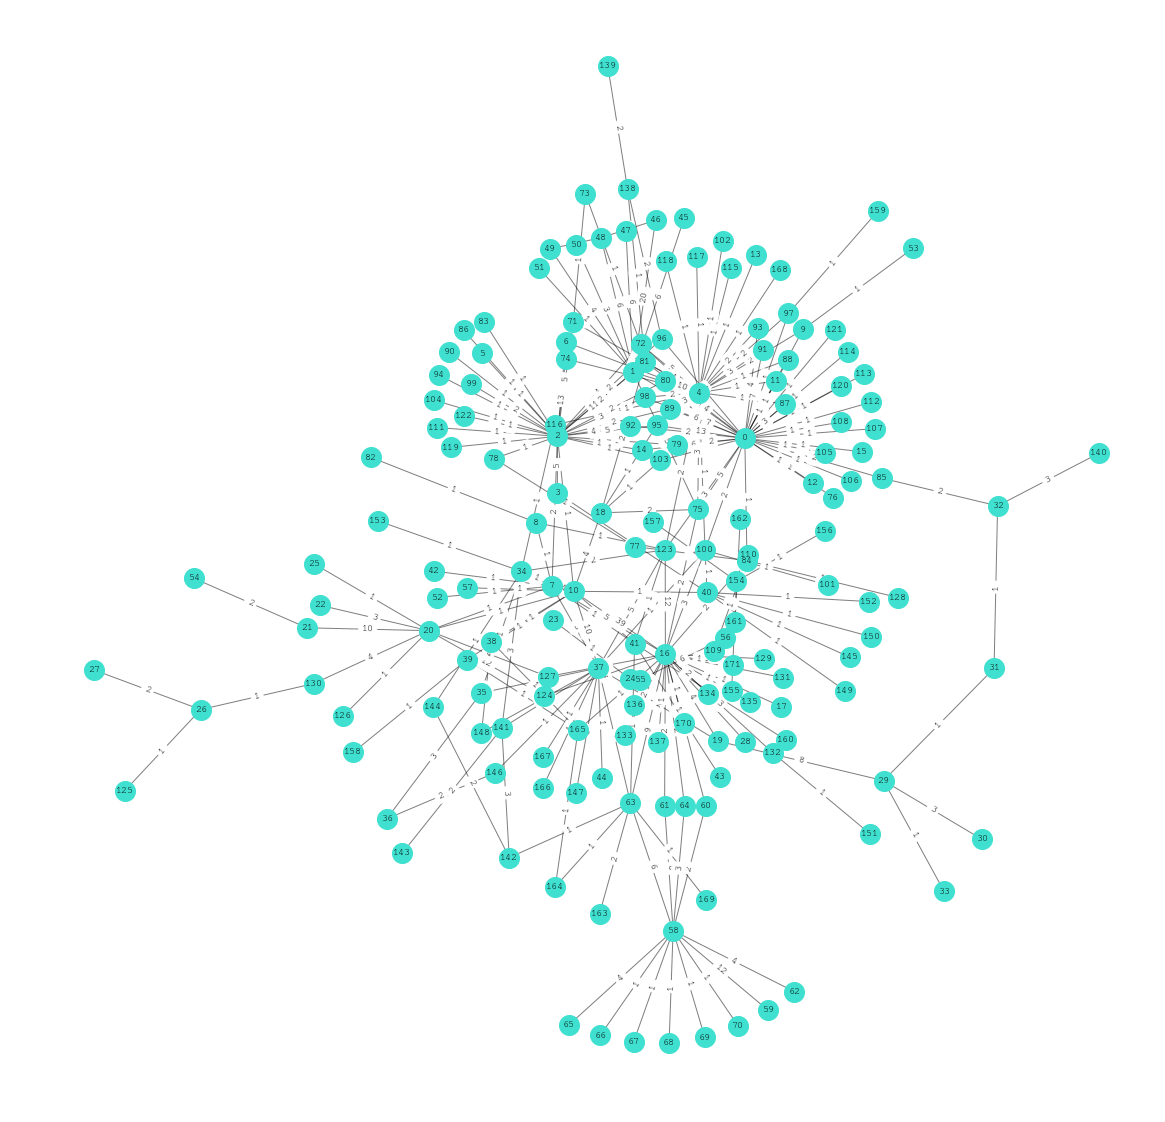

In [89]:
fig = plt.figure(figsize=(20, 20))

# nodes

nx.draw_networkx_nodes(G, pos, node_color='#40E0D0', node_size=400)

# edges
nx.draw_networkx_edges(G, pos, edgelist=edges,
                       width=1, alpha=0.5)

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='FreeMono')

edge_labels = nx.get_edge_attributes(G,'w')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_family='FreeMono', clip_on=False)

plt.axis('off')
#plt.show()
plt.savefig('ADV_graph.png', dpi=200)

In [97]:
deriv_array[1].example

'быстро'

In [96]:
deriv_array[1].wr_before

{('о', 'б'): 2,
 ('о', 'в'): 5,
 ('о', 'г'): 5,
 ('о', 'д'): 1,
 ('о', 'к'): 19,
 ('о', 'л'): 7,
 ('о', 'м'): 1,
 ('о', 'н'): 47,
 ('о', 'р'): 15,
 ('о', 'т'): 5,
 ('о', 'х'): 2,
 ('о', 'ш'): 1,
 ('о', 'щ'): 1}

In [98]:
deriv_array[1].wl_after

{('', 'а'): 1,
 ('', 'б'): 7,
 ('', 'в'): 5,
 ('', 'г'): 4,
 ('', 'д'): 13,
 ('', 'е'): 1,
 ('', 'ж'): 4,
 ('', 'з'): 2,
 ('', 'к'): 4,
 ('', 'л'): 1,
 ('', 'м'): 10,
 ('', 'н'): 7,
 ('', 'о'): 4,
 ('', 'п'): 12,
 ('', 'р'): 6,
 ('', 'с'): 15,
 ('', 'т'): 6,
 ('', 'у'): 2,
 ('', 'х'): 4,
 ('', 'ч'): 2,
 ('', 'ш'): 1}